<a href="https://colab.research.google.com/github/davifcs/ia376/blob/main/Aula_6_Image_Captioning_Completo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Enunciado

Crie um modelo de image captioning completo similar ao do paper Show, Attend and Tell mas usando a EfficientNet (pré-treinada) como codificador e usando o codificador + decodificador do T5, BART ou Pegasus. Para o decodificador, sugerimos utilizar a biblioteca da Hugginface e adaptar o codificador do Transformers para ter como entrada o feature map extraído da imagem.

Sugerimos ler a página abaixo para se familizarem como a biblioteca implementa a arquitetura encoder-decoder: https://huggingface.co/transformers/model_doc/encoderdecoder.html

## Track Básica: Usar MS COCO reduzido (23k exemplos de treino)

Download do dataset MS COCO reduzido para 23k exemplos:

In [ ]:
!gsutil -m cp -n gs://neuralresearcher_data/unicamp/ia376j_2020s2/aula3/*_IMAGES_coco_5_cap_per_img.hdf5 .
!gsutil -m cp -n gs://neuralresearcher_data/unicamp/ia376j_2020s2/aula3/*_CAPTIONS_coco_5_cap_per_img.json .

Copying gs://neuralresearcher_data/unicamp/ia376j_2020s2/aula3/TEST_IMAGES_coco_5_cap_per_img.hdf5...
Copying gs://neuralresearcher_data/unicamp/ia376j_2020s2/aula3/TRAIN_IMAGES_coco_5_cap_per_img.hdf5...
Copying gs://neuralresearcher_data/unicamp/ia376j_2020s2/aula3/VAL_IMAGES_coco_5_cap_per_img.hdf5...
- [3/3 files][  4.7 GiB/  4.7 GiB] 100% Done  41.3 MiB/s ETA 00:00:00           
Operation completed over 3 objects/4.7 GiB.                                      
Copying gs://neuralresearcher_data/unicamp/ia376j_2020s2/aula3/TEST_CAPTIONS_coco_5_cap_per_img.json...
Copying gs://neuralresearcher_data/unicamp/ia376j_2020s2/aula3/TRAIN_CAPTIONS_coco_5_cap_per_img.json...
Copying gs://neuralresearcher_data/unicamp/ia376j_2020s2/aula3/VAL_CAPTIONS_coco_5_cap_per_img.json...
/ [3/3 files][  6.8 MiB/  6.8 MiB] 100% Done                                    
Operation completed over 3 objects/6.8 MiB.                                      


In [ ]:
!pip install efficientnet-pytorch transformers
!pip install tdqm
!pip install sacrebleu

     |████████████████████████████████| 1.3MB 6.9MB/s 
     |████████████████████████████████| 1.1MB 29.5MB/s 
     |████████████████████████████████| 2.9MB 37.9MB/s 
     |████████████████████████████████| 890kB 45.4MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp36-none-any.whl size=16031 sha256=7c410fd5bd2045344d1f8b4e9ee3977358a864febda506ec0797f51ae5ab54d5
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=ee81f65ffcc7f99c66ae7885c69b609cbf2bb3b06667489edae227c4fd50015b
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built efficientnet-pytorch sacremoses
  Created wheel for tdqm: filename=tdqm-0.0.1-cp36-none-any.whl size=1322 sha256=ca8e6340e1de9ed52d3ef58c6a754c2503640a84a5e32a58fc71f29379c6f732
  Stored in directory: /ro

O dataset deve conter 23.520, 1.052 e 1.047 imagens de treino, validação e teste.

In [ ]:
import h5py
import json
import sacrebleu

import torch
from torch import nn
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from torch.optim import lr_scheduler
from torchsummary import summary 

import efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

from transformers import T5ForConditionalGeneration
from transformers import T5Tokenizer

import numpy as np
from PIL import Image
from collections import OrderedDict
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm 

In [ ]:
# Configurações gerais
ENCODER = 'efficientnet-b0'
DECODER = 't5-small'
BATCH_SIZE = 32
NUM_WORKERS = 2

Image shape: (23520, 3, 256, 256)
Label lenght: 23520
Label: ['A woman in a room with a cat.', 'a woman is holding a cat in her kitchen', 'A woman is holding a cat in her kitchen.', 'A girl smiles as she holds a cat and wears a brightly colored skirt.', 'A woman is working in a kitchen carrying a soft toy.']


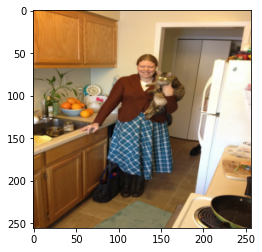

In [ ]:
train_label = json.load(open("/content/TRAIN_CAPTIONS_coco_5_cap_per_img.json"))
train_img = "/content/TRAIN_IMAGES_coco_5_cap_per_img.hdf5"

val_img = "/content/VAL_IMAGES_coco_5_cap_per_img.hdf5"
val_label = json.load(open("/content/VAL_CAPTIONS_coco_5_cap_per_img.json"))

test_img = "/content/TEST_IMAGES_coco_5_cap_per_img.hdf5"
test_label = json.load(open("/content/TEST_CAPTIONS_coco_5_cap_per_img.json"))

h5_file = h5py.File(train_img, 'r')
print("Image shape:", h5_file['images'].shape)
print("Label lenght:", len(train_label))

plt.imshow(np.transpose(h5_file['images'][0], (1, 2, 0)))

print("Label:", train_label[0])

In [ ]:
tokenizer = T5Tokenizer.from_pretrained(DECODER)

class MSCOCODataset(Dataset):
    def __init__(self, 
                 path_imgs, 
                 path_labels,
                 transform = None,
                 label_max_length: int = 32):
        h5_file = h5py.File(path_imgs, 'r')
        self.images = h5_file['images']
        self.labels = np.array(path_labels)
        self.transform = transform
        self.tokenizer = tokenizer
        self.label_max_length = label_max_length

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image, label = np.array(self.images[idx]), self.labels[idx]
        image = np.transpose(image, (1, 2, 0)) 

        if self.transform is not None:
            image = self.transform(image)

        tokenized_label = self.tokenizer(label[0], 
                                           max_length=self.label_max_length,
                                           padding='max_length', truncation=True, 
                                           return_tensors='pt')
        label_token_ids = tokenized_label['input_ids'].squeeze(0)

        return image, label[0], label_token_ids

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = MSCOCODataset(train_img, train_label, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True,  num_workers=NUM_WORKERS)

valset = MSCOCODataset(val_img, val_label, transform=transform)

valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=NUM_WORKERS)

testset = MSCOCODataset(test_img, test_label, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=NUM_WORKERS)

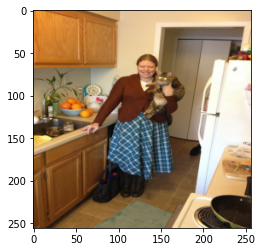

A woman in a room with a cat.
tensor([  71, 2335,   16,    3,    9,  562,   28,    3,    9, 1712,    5,    1,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])


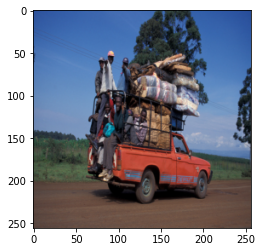

A group of people riding on the back of a loaded red pickup truck.
tensor([   71,   563,    13,   151,  7494,    30,     8,   223,    13,     3,
            9, 10346,  1131, 12820,  4072,     5,     1,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])


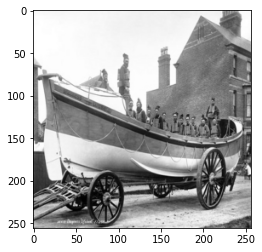

A large boat filled with mean on wheels.
tensor([  71,  508, 3432, 3353,   28, 1243,   30, 8277,    5,    1,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])


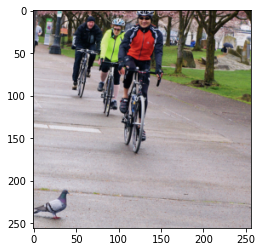

three bicycle riders some trees and a pigeon
tensor([  386, 12679, 14149,   128,  3124,    11,     3,     9,     3,  9905,
           15,   106,     1,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])


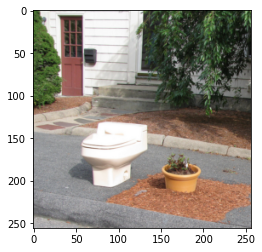

A white toilet sitting on a sidewalk outside.
tensor([   71,   872,  6699,  3823,    30,     3,     9, 21393,  1067,     5,
            1,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])


In [ ]:
SAMPLES = 4

for i in range(0, SAMPLES+1):
  img, labels, tokens = trainset[i]
  plt.imshow(np.transpose(img, (1,2,0)))
  plt.show()
  print(labels)
  print(tokens)

In [ ]:
class Captioning(nn.Module):
    def __init__(self, seq_max_length=64):
        super(Captioning, self).__init__()
        
        self.encoder = EfficientNet.from_pretrained(ENCODER)

        for param in self.encoder.parameters(): 
            param.requires_grad = False

        self.decoder = T5ForConditionalGeneration.from_pretrained(DECODER)

        self.cnn = nn.Conv2d(in_channels=1280,
                              out_channels=self.decoder.config.d_model,
                              kernel_size=1)
        self.seq_max_length = seq_max_length
        
    def forward(self, images, labels=None):
        features = self.encoder.extract_features(images)  # (batch_size, 1028, image_size, image_size)
        features = self.cnn(features) # (batch_size, decoder_size, image_size, image_size)
        features = torch.relu(features) 
        features = features.view(features.size(0), -1, features.size(1)) # (batch_size, encoded_image_size, decoder_size)


        if labels is not None:
          loss = self.decoder(inputs_embeds=features, labels=labels)[0]
          return loss

        else:
          decoded_ids = torch.full((images.shape[0], 1), 
                                   model.decoder.config.decoder_start_token_id, 
                                   dtype=torch.long).to(device) 

          for i in range(self.seq_max_length):
            logits = self.decoder(inputs_embeds=features, 
                                  decoder_input_ids=decoded_ids)[0]
            next_token_logits = logits[:, -1, :]
            next_token_id = next_token_logits.argmax(1).unsqueeze(-1)
            decoded_ids = torch.cat([decoded_ids, next_token_id], dim=-1)
            logits = decoded_ids
          return logits

In [ ]:
@torch.enable_grad()
def train(model, device, dataloader, learning_rate, optimizer, epoch):
  
  model.train()

  train_batch = tqdm(dataloader, total=len(dataloader))
  running_loss = 0.0

  for images, _, labels_tokens_ids  in train_batch:
    inputs = images.to(device)
    labels = labels_tokens_ids.to(device)
    optimizer.zero_grad()
    loss = model(inputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  running_loss = running_loss/len(train_batch)
  return running_loss

In [ ]:
@torch.no_grad()
def val(model, device, dataloader, epoch):
  
    model.eval()

    val_batch = tqdm(dataloader, total=len(dataloader))
    val_loss = 0.0
    min_error = float("inf")

    for images, _, labels_tokens_ids in val_batch:
      inputs = images.to(device)
      labels = labels_tokens_ids.to(device)
      loss = model(inputs, labels)
      val_loss += loss.item()
    val_loss = val_loss/len(val_batch)  
    return val_loss

In [ ]:
device = torch.device('cpu')
if torch.cuda.is_available():
  device = torch.device('cuda')
print('GPU available:', device)
 
model = Captioning()
model = model.to(device)
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 15
 
for epoch in range(epochs):
    train_loss = train(model, device, trainloader, learning_rate, optimizer, epoch)
    val_loss = val(model, device, valloader, epoch)
 
    print('Epoch %d - Train Loss %.5f - Validation Loss %.5f' 
          %(epoch, train_loss, val_loss))

GPU available: cuda


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0



Epoch 0 - Train Loss 1.33188 - Validation Loss 1.16475



Epoch 1 - Train Loss 1.15907 - Validation Loss 1.14757



Epoch 2 - Train Loss 1.08060 - Validation Loss 1.08417



Epoch 3 - Train Loss 1.02989 - Validation Loss 1.06764



Epoch 4 - Train Loss 0.98961 - Validation Loss 1.06653



Epoch 5 - Train Loss 0.95591 - Validation Loss 1.05610



Epoch 6 - Train Loss 0.92638 - Validation Loss 1.06492



Epoch 7 - Train Loss 0.89908 - Validation Loss 1.06488



Epoch 8 - Train Loss 0.87245 - Validation Loss 1.08277



Epoch 9 - Train Loss 0.84603 - Validation Loss 1.08408



Epoch 10 - Train Loss 0.82280 - Validation Loss 1.09118



Epoch 11 - Train Loss 0.80194 - Validation Loss 1.09695



Epoch 12 - Train Loss 0.77954 - Validation Loss 1.10520



Epoch 13 - Train Loss 0.75836 - Validation Loss 1.10249



Epoch 14 - Train Loss 0.73948 - Validation Loss 1.13037


##Teste


BLEU 1-gram 36.56 - BLEU 4-gram 3.61 - BLEU Score 8.48


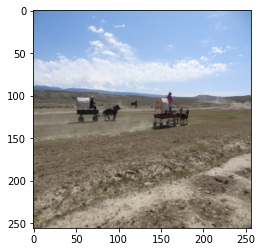

Label: A couple of people riding horse drawn carriage through the desert.
Predicted: A plane sitting on the tarmac with people walking around.


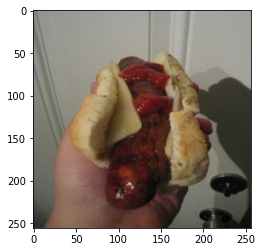

Label: Someone is holding up a hot dog with cheese on a bun.
Predicted: A large truck is parked in front of a building.


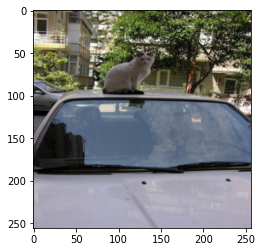

Label: A cat is sitting on the hood of a car in a residential area.
Predicted: A cat is laying on a bed next to a remote control.


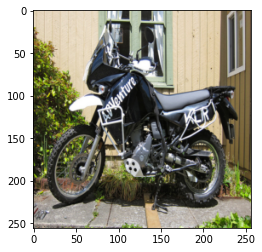

Label: A motorcycle sits parked outside of the window.
Predicted: A dog is sitting on a rug in front of a door.


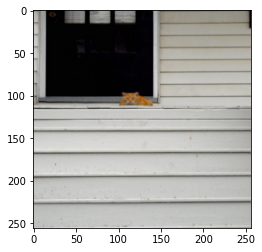

Label: An orange cat sitting in front of a door to a house.
Predicted: A cat is sitting in a bathroom sink.


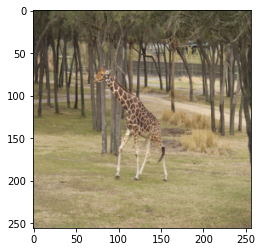

Label: A juvenile giraffe walking through the brown grass.
Predicted: A dog laying on a bed next to a pair of shoes.


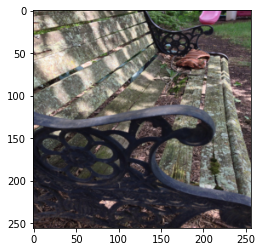

Label: a worn wooden bench beneath some shade trees
Predicted: A dog is running through the water with a Frisbee in its mouth.


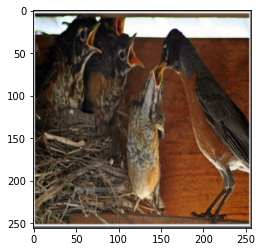

Label: A mother bird feeds her baby birds by the nest.
Predicted: A group of giraffes standing in a field next to a tree.


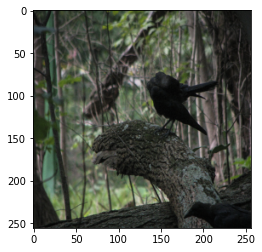

Label: two blackbirds mating on a large branch with a forest in the  background
Predicted: A man riding a horse next to a tall building.


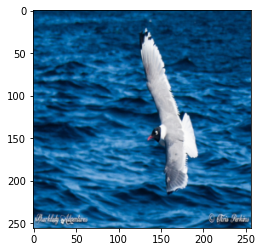

Label: A white bird fly's in the air above the blue water.
Predicted: A man laying on a bed with a cat and a laptop.


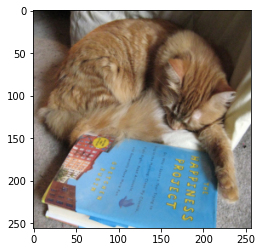

Label: A cat is sleeping  in front of a book.
Predicted: A park bench sits in the grass near a tree.


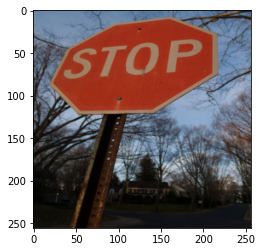

Label: A large red stop sign on a metal pole.
Predicted: A black cat is sitting in a bathroom sink.


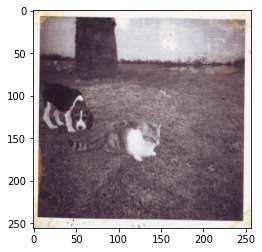

Label: A curious dog sniffs near a cat that's sitting on the grass.
Predicted: A cat is drinking out of a toilet.


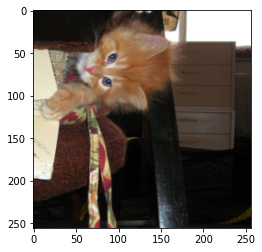

Label: A kitten looking out sideways from a chair.
Predicted: A plane flying in the air with a blue sky background.


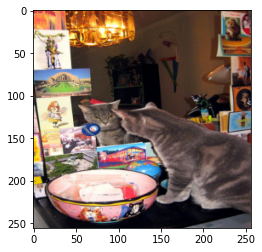

Label: A large gray cat sitting in front of a mirror next to a pink bowl.
Predicted: A traffic light with a car passing by.


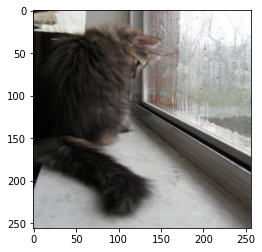

Label: Young kitten along windowpane watching the rain tap on the glass.
Predicted: A plane flying in the sky with a blue sky background.


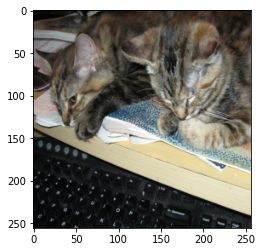

Label: Two cats that are laying down on a desk.
Predicted: A giraffe standing in the middle of a grassy field.


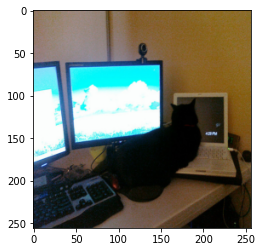

Label: A cat is watching the clouds on the monitor.
Predicted: A train car is sitting on the tracks in a park.


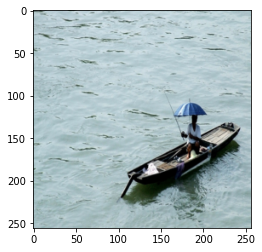

Label: A man riding on the back of a boat floating in water.
Predicted: A bird perched on top of a piece of metal.


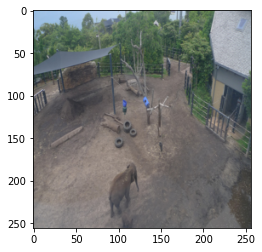

Label: A small elephant standing next to a house.
Predicted: A cat is sitting on a bench near a window.


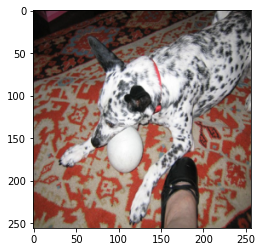

Label: A dog laying on a rug while chewing on a ball next to someone's foot. 
Predicted: A black and white photo of a person holding a cat.


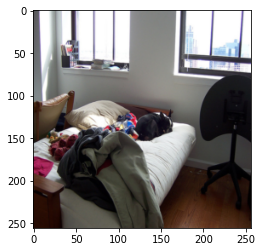

Label: A very cute dog laying on a big bed.
Predicted: A dog is laying on a couch with a stuffed animal.


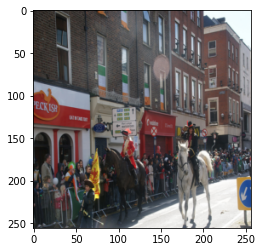

Label: A crowd is watching horses go down the street.
Predicted: A dog is laying on the ground with a frisbee in its mouth.


In [15]:
model.eval()

test_batch = tqdm(testloader, total=len(testloader))

predicted_labels = []
target_labels = []

bleu_1 = 0
bleu_4 = 0
bleu_score = 0

for images, labels, tokens in test_batch:
    inputs = images.to(device)
    tokens = tokens.to(device)

    predicted_token_ids = model(inputs)

    predicted_labels_batch = [tokenizer.decode(token, skip_special_tokens=True) for token in predicted_token_ids]

    predicted_labels += predicted_labels_batch
    target_labels += labels 

for predicted, target in zip(predicted_labels, target_labels):
  bleu = sacrebleu.corpus_bleu(predicted, target)
  bleu_1 += bleu.precisions[0]
  bleu_4 += bleu.precisions[3]
  bleu_score += bleu.score

print('BLEU 1-gram %.2f - BLEU 4-gram %.2f - BLEU Score %.2f' % 
      (bleu_1/len(predicted_labels), bleu_4/len(predicted_labels), bleu_score/len(predicted_labels)))

for image, label, predicted in zip(images, labels, predicted_labels):
  plt.imshow(np.transpose(image, (1,2,0)))
  plt.show()
  print('Label:', label)
  print('Predicted:', predicted)

